### Sensor Component Failure Prediction

###### Data: Sensor Data
###### Problem Statement:
The system in focus is the Air Pressure System (APS) which generates pressurized air that are utilized in various fuctions like braking, gear change etc. The dataset's positive class corresponds to component failures for a soecific component of the APS system. The negative class corrsponds to the vehicles with failures for component not related to the APS system.

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer, SimpleImputer

#### Data Exploration
* Dealing with missing values

In [2]:
df = pd.read_csv("aps_failure_training_set1.csv", na_values='na')
df.head()

class  aa_000  ab_000  ac_000  ad_000  ae_000  af_000  ag_000    ag_001  \
0   pos  153204     0.0   182.0     NaN     0.0     0.0     0.0       0.0   
1   pos  453236     NaN  2926.0     NaN     0.0     0.0     0.0       0.0   
2   pos   72504     NaN  1594.0  1052.0     0.0     0.0     0.0     244.0   
3   pos  762958     NaN     NaN     NaN     NaN     NaN   776.0  281128.0   
4   pos  695994     NaN     NaN     NaN     NaN     NaN     0.0       0.0   

      ag_002  ...     ee_002     ee_003     ee_004     ee_005     ee_006  \
0        0.0  ...   129862.0    26872.0    34044.0    22472.0    34362.0   
1      222.0  ...  7908038.0  3026002.0  5025350.0  2025766.0  1160638.0   
2   178226.0  ...  1432098.0   372252.0   527514.0   358274.0   332818.0   
3  2186308.0  ...        NaN        NaN        NaN        NaN        NaN   
4        0.0  ...  1397742.0   495544.0   361646.0    28610.0     5130.0   

     ee_007    ee_008  ee_009  ef_000  eg_000  
0       0.0       0.0     0.0     0.0     0.0  
1  533834.0  493800.0  6914.0     0.0     0.0  
2  284178.0    3742.0     0.0     0.0     0.0  
3       NaN       NaN     NaN     NaN     NaN  
4     212.0       0.0     0.0     NaN     NaN  

[5 rows x 171 columns]

* Lets check which columns contains null values

In [3]:
df.isnull().sum()

class         0
aa_000        0
ab_000    27896
ac_000     2141
ad_000     9200
          ...  
ee_007      379
ee_008      379
ee_009      379
ef_000     1730
eg_000     1729
Length: 171, dtype: int64

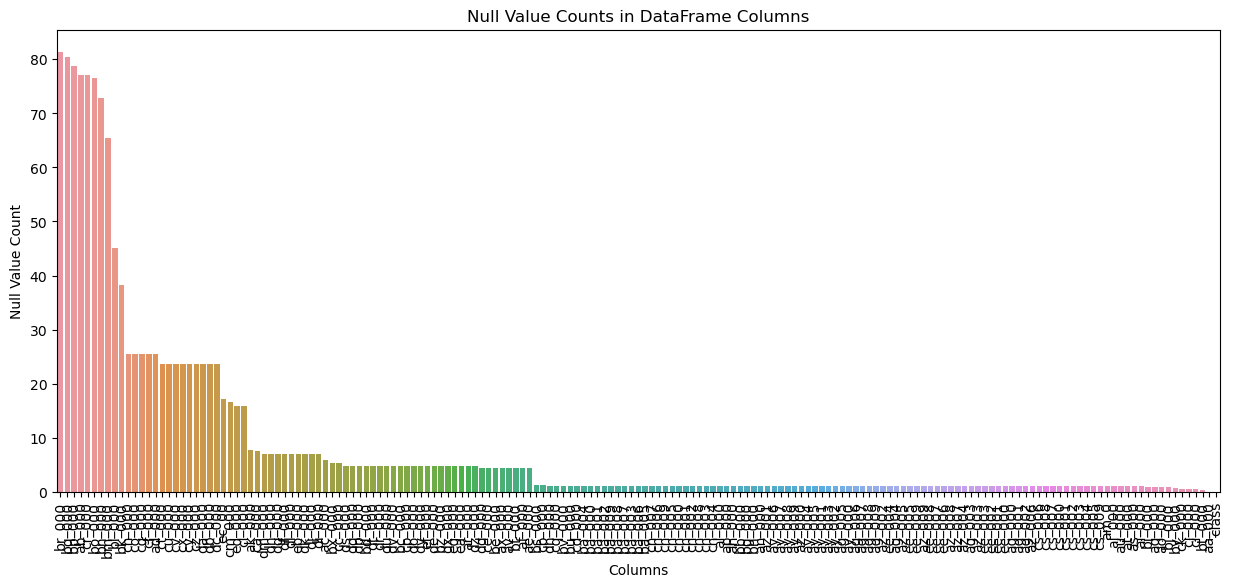

In [4]:
null_val = df.isnull().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending=False)
plt.figure(figsize=(15, 6))
sns.barplot(x=null_val.index, y=null_val.values.T[0])
plt.xlabel('Columns')
plt.ylabel('Null Value Count')
plt.title('Null Value Counts in DataFrame Columns')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.show()

* There seems to be very high missing values in many columns. Lets get rid of the columns where there are more than 70% missing values

In [5]:
def delete_sparse_columns(df):
    total_datapoints = len(df)
    
    for col in df.columns:
        if df[col].isnull().sum()/float(total_datapoints) > 0.7:
            df = df.drop([col], axis=1)
            print("Deleted column:", col)
        
    return df

In [6]:
df = delete_sparse_columns(df)
df.shape

Deleted column: ab_000
Deleted column: bn_000
Deleted column: bo_000
Deleted column: bp_000
Deleted column: bq_000
Deleted column: br_000
Deleted column: cr_000


(36188, 164)

* Now we deal with the other missing values. Check total percentage of cells with remaining missing values.

In [7]:
print(f"The percentage of missing values {df.isnull().sum().values.sum()/np.product(df.shape) * 100} %")

The percentage of missing values 5.37059852747306 %


##### We can use missing values imputers to impute missing values in the columns.
* We will be using different imputers and test with classification algorithms to check the best imputer
* Before we use imputer lets check the distribution of the target variable

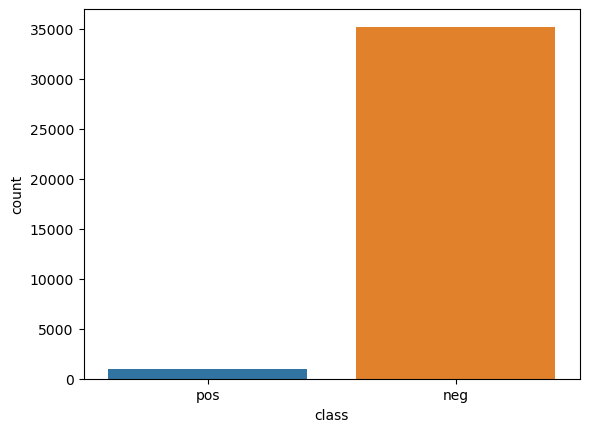

In [8]:
sns.countplot(data=df, x='class')
plt.show()

* The variable is highly imbalanced. We need to do some oversampling for the minority class to create optimized model for prediction
* Using SMOTE to oversample will help in overcoming the imbalance

In [9]:
# lets separate the input and target variable
X = df.drop(['class'], axis=1)
y = df['class']
X.shape, y.shape

((36188, 163), (36188,))

In [10]:
import time
import concurrent.futures
import os

os.makedirs("plots/", exist_ok=True)

def plot_column(col):
    plt.figure(figsize=(6, 4))
    sns.distplot(x=X[col])
    plt.title(f"Distribution of {col}")
#     plt.show()
    plt.savefig(f"plots/{col}.png")
    plt.close()
    
columns_to_plot = X.columns.to_list()


In [11]:
tik = time.time()

with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
    executor.map(plot_column, columns_to_plot)

executor.shutdown()

tok = time.time()
print(f"Time taken {tok - tik}")

Time taken 132.87467908859253


* Lets look at the plots

In [12]:
plot_dir = "plots/"
plot_files = os.listdir(plot_dir)

# Define the number of columns per row
columns_per_row = 3

# Calculate the number of rows needed
num_rows = (len(plot_files) + columns_per_row - 1) // columns_per_row

# Create a figure with appropriate size
plt.figure(figsize=(20, num_rows * 5))

for i, plot in enumerate(plot_files):
    plt.subplot(num_rows, columns_per_row, i+1)
    img = plt.imread("plots/"+plot)
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

* Since the distribution of all the variables are not normally distributed due the extreme outliers present standard scaling won't be appropriate.
* Rather we can scale with RobustScaler.

#### Steps needed to find good imputer and model
* Impute missing values (We will experiment with different imputing techniques and check each model score)
* Handle imbalanced dataset with SMOTETomek
* Evaluate classifier models based on accuracy, F1 score, Precision, Recall and ROC-AUC score.

##### Write two functions for checking classifier performance and evaluating models
* classifier_performance() function to check the score of the classifier based on accuracy, F1 score, Precision, Recall, number of false positives and false negatives and ROC-AUC score on both the training set and test set.
* In the case of a vehicle sensor failure there is always a risk of accidents on road so for the report to give maximum efficiency we will try to reduce the false negatives so to reduce the chance of the algorithm to flag a positive failure as negative. For that we will state an equation with more weight towards false negatives to determine the best model

In [13]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score

In [14]:
def classifier_performance(y_true, y_pred):
    
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    return (acc, roc, f1, precision, recall)

In [15]:
def cost(y_true, y_pred):
    # extract the values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # construct the cost equation
    cost = 10*fp + 500*fn
    
    return cost

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
def evaluate_models(X, y, models:dict):
    
    # split into train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    # store the costs and accuracies
    costs = []
    accuracies = []
    model_name = []
    
    for m_name, model in models.items():
        
        model_name.append(m_name)
        
        # fit the model
        model.fit(X_train, y_train)
        
        # prediction on training and test set
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # training set performance
        tr_acc, tr_roc, tr_f1, tr_precision, tr_recall = classifier_performance(y_train, y_train_pred)
        tr_cost = cost(y_train, y_train_pred)
        
        # test set performance
        te_acc, te_roc, te_f1, te_precision, te_recall = classifier_performance(y_test, y_test_pred)
        te_cost = cost(y_test, y_test_pred)
        
        print(m_name)
        
        print('='*50)
        print("Model Performance for training set")
        print(f"- Accuracy: {tr_acc}")
        print(f"- ROC-AUC score: {tr_roc}")
        print(f"- F1 Score: {tr_f1}")
        print(f"- Precision: {tr_precision}")
        print(f"- Recall: {tr_recall}")
        print(f"- COST: {tr_cost}")
        
        print("-"*50)
        
        print("Model Performance for test set")
        print(f"- Accuracy: {te_acc}")
        print(f"- ROC-AUC score: {te_roc}")
        print(f"- F1 Score: {te_f1}")
        print(f"- Precision: {te_precision}")
        print(f"- Recall: {te_recall}")
        print(f"- COST: {te_cost}")
        
        accuracies.append(te_acc)
        costs.append(te_cost)
        
        print("=="*50)
    
    data_dict = {
        "Model Name": model_name,
        "Costs": costs
    }

    report = pd.DataFrame(data=data_dict).sort_values(by=['Costs'])
    
    return report
        

#### Now lets check which imputer will give much better performance
##### 1. KNN Imputer
* For *KNN Imputer* we will need to determine the number of neighbors appropriate

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

In [19]:
# transform the data
rbst_scaler = RobustScaler()
X_t = rbst_scaler.fit_transform(X)

In [20]:
# create the pipeline
knn_pipe = make_pipeline(KNNImputer(), LogisticRegression())

In [21]:
results = []
neighbors = [i for i in range(3, 10, 2)]
for i in tqdm(neighbors):
    knn_pipe.set_params(knnimputer__n_neighbors = i)
    score = cross_val_score(knn_pipe, X_t, y, scoring='accuracy', cv=2, n_jobs=-1)
    results.append(score)
    print(f"N_neighbors: {i} ---> Accuracy: {score}")
    

 25%|████████████████████▊                                                              | 1/4 [07:39<22:57, 459.21s/it]

N_neighbors: 3 ---> Accuracy: [0.71200398 0.76478391]



 50%|█████████████████████████████████████████▌                                         | 2/4 [15:12<15:11, 455.58s/it]

N_neighbors: 5 ---> Accuracy: [0.68133083 0.76334697]



 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [23:10<07:46, 466.08s/it]

N_neighbors: 7 ---> Accuracy: [0.6885708 0.6828783]


100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [30:29<00:00, 457.43s/it]

N_neighbors: 9 ---> Accuracy: [0.67674367 0.7564386 ]


* So it seems 7 neighbors give best acucracy

In [19]:
# Lets impute missing values in X with KNN imputer with 3 neighbors
knn_pipe = make_pipeline(KNNImputer(n_neighbors=3), RobustScaler())
# impute missing values
X_knn = knn_pipe.fit_transform(X)

In [20]:
from imblearn.combine import SMOTETomek

In [21]:
y = y.map({'pos': 1, 'neg': 0})
y

0        1
1        1
2        1
3        1
4        1
        ..
36183    0
36184    0
36185    0
36186    0
36187    0
Name: class, Length: 36188, dtype: int64

In [22]:
# initialize SMOTE
smt_imb = SMOTETomek(random_state=99, sampling_strategy='minority', n_jobs=-1)
# fit and resample the data
X_res, y_res = smt_imb.fit_resample(X_knn, y)

* Intialize models dictionary

In [22]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [23]:
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "AdaBoostClassifier": AdaBoostClassifier(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "ExtraTreesClassifier": ExtraTreesClassifier(),
    "LogisticRegression": LogisticRegression(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoostClassifier": CatBoostClassifier(verbose=0)
}

In [25]:
report_knn = evaluate_models(X_res, y_res, models)

RandomForestClassifier
Model Performance for training set
- Accuracy: 1.0
- ROC-AUC score: 1.0
- F1 Score: 1.0
- Precision: 1.0
- Recall: 1.0
- COST: 0
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9908812424307188
- ROC-AUC score: 0.990945393236973
- F1 Score: 0.9908059186898432
- Precision: 0.9858490566037735
- Recall: 0.9958128790066416
- COST: 15490
AdaBoostClassifier
Model Performance for training set
- Accuracy: 0.975474218541277
- ROC-AUC score: 0.9754704896233989
- F1 Score: 0.9755803436840518
- Precision: 0.9745606575963719
- Recall: 0.9766021658086277
- COST: 336680
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9742110137493767
- ROC-AUC score: 0.9742422181851067
- F1 Score: 0.9739380849532038
- Precision: 0.9712808730614589
- Recall: 0.976609875830205
- COST: 83000
GradientBoostingClassifier
Model Performance for training set
- Accuracy: 0.9838810223528364
- ROC-AUC score: 0.9

* Lets look at the report

In [28]:
report_knn.sort_values(by=['Costs'])

Model Name   Costs
7               XGBClassifier    7080
8          CatBoostClassifier    9680
3        ExtraTreesClassifier   11840
0      RandomForestClassifier   15490
5      DecisionTreeClassifier   39280
6        KNeighborsClassifier   47270
2  GradientBoostingClassifier   51040
1          AdaBoostClassifier   83000
4          LogisticRegression  329850

* For KNN Imputer XGB classifier seems to be giving lowest cost value

#### 2. Simple Imputer (strategy='median')
* Lets check with Simple Imputer with strategy median

In [34]:
# initialize pipeline with simple imputer and robust scaler
median_pipe = make_pipeline(SimpleImputer(strategy='median'), RobustScaler())
# transform dataset
X_med = median_pipe.fit_transform(X)

In [35]:
# initialize SMOTE
smt_imb = SMOTETomek(random_state=99, sampling_strategy='minority', n_jobs=-1)
# fit and resample the data
X_res, y_res = smt_imb.fit_resample(X_med, y)

In [36]:
# Lets evaluate the models on median imputed data
report_med = evaluate_models(X_res, y_res, models)

RandomForestClassifier
Model Performance for training set
- Accuracy: 1.0
- ROC-AUC score: 1.0
- F1 Score: 1.0
- Precision: 1.0
- Recall: 1.0
- COST: 0
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9915792478412903
- ROC-AUC score: 0.991630548216323
- F1 Score: 0.991501008354941
- Precision: 0.9875179340028695
- Recall: 0.9955163436505641
- COST: 16370
AdaBoostClassifier
Model Performance for training set
- Accuracy: 0.9739701343419386
- ROC-AUC score: 0.9739686141770648
- F1 Score: 0.9740654496329346
- Precision: 0.9737019794591136
- Recall: 0.9744291912653816
- COST: 366900
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9751659173624492
- ROC-AUC score: 0.9752068181713535
- F1 Score: 0.9749207264341309
- Precision: 0.9715598965814422
- Recall: 0.9783048886317617
- COST: 76980
GradientBoostingClassifier
Model Performance for training set
- Accuracy: 0.9840680808549357
- ROC-AUC score: 0.

In [37]:
report_med

Model Name   Costs
7               XGBClassifier    5570
8          CatBoostClassifier    8210
3        ExtraTreesClassifier   12500
0      RandomForestClassifier   16370
2  GradientBoostingClassifier   38700
5      DecisionTreeClassifier   39960
6        KNeighborsClassifier   57130
1          AdaBoostClassifier   76980
4          LogisticRegression  319240

* Slightly better results with XGBClassifier.

#### 3. Simple Imputer (strategy='constant')
* Lets try with Simple Imputer keeping the strategy to constant

In [24]:
# initialize pipeline with simple imputer and robust scaler
const_pipe = make_pipeline(SimpleImputer(strategy='constant', fill_value=0), RobustScaler())
# transform dataset
X_const = const_pipe.fit_transform(X)

In [25]:
# initialize SMOTE
smt_imb = SMOTETomek(random_state=99, sampling_strategy='minority', n_jobs=-1)
# fit and resample the data
X_res, y_res = smt_imb.fit_resample(X_const, y)

In [26]:
report_const = evaluate_models(X_res, y_res, models)

RandomForestClassifier
Model Performance for training set
- Accuracy: 1.0
- ROC-AUC score: 1.0
- F1 Score: 1.0
- Precision: 1.0
- Recall: 1.0
- COST: 0
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9924372146118722
- ROC-AUC score: 0.992473309209977
- F1 Score: 0.9924079644750036
- Precision: 0.9880205362236166
- Recall: 0.9968345323741007
- COST: 11840
AdaBoostClassifier
Model Performance for training set
- Accuracy: 0.9741170174812701
- ROC-AUC score: 0.9741154671373982
- F1 Score: 0.9741883838833052
- Precision: 0.9735129946314929
- Recall: 0.9748647109085731
- COST: 360450
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9741723744292238
- ROC-AUC score: 0.9741717862619047
- F1 Score: 0.9739605812113366
- Precision: 0.9738204833141542
- Recall: 0.9741007194244604
- COST: 91820
GradientBoostingClassifier
Model Performance for training set
- Accuracy: 0.9833392793435605
- ROC-AUC score: 0

In [27]:
report_const

Model Name   Costs
7               XGBClassifier    4010
8          CatBoostClassifier    8150
0      RandomForestClassifier   11840
3        ExtraTreesClassifier   11980
5      DecisionTreeClassifier   36680
6        KNeighborsClassifier   42470
2  GradientBoostingClassifier   50130
1          AdaBoostClassifier   91820
4          LogisticRegression  101850

* The cost came down, although not by much

#### 4. Simple Imputer (strategy='mean')
* Lets try with Simple Imputer keeping the strategy to mean, which will impute the mean of the column in missing values places

In [42]:
# initialize pipeline with simple imputer and robust scaler
mean_pipe = make_pipeline(SimpleImputer(strategy='mean'), RobustScaler())
# transform dataset
X_mean = mean_pipe.fit_transform(X)

In [43]:
# initialize SMOTE
smt_imb = SMOTETomek(random_state=99, sampling_strategy='minority', n_jobs=-1)
# fit and resample the data
X_res, y_res = smt_imb.fit_resample(X_mean, y)

In [44]:
report_mean = evaluate_models(X_res, y_res, models)

RandomForestClassifier
Model Performance for training set
- Accuracy: 1.0
- ROC-AUC score: 1.0
- F1 Score: 1.0
- Precision: 1.0
- Recall: 1.0
- COST: 0
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9933000712758375
- ROC-AUC score: 0.9933437411703876
- F1 Score: 0.9932684044686336
- Precision: 0.9885958660014256
- Recall: 0.9979853216290113
- COST: 7800
AdaBoostClassifier
Model Performance for training set
- Accuracy: 0.9764611546685673
- ROC-AUC score: 0.9764614016521281
- F1 Score: 0.9765126326831783
- Precision: 0.9766689191592275
- Recall: 0.9763563962170234
- COST: 339060
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9759087669280114
- ROC-AUC score: 0.9759039516200801
- F1 Score: 0.9756729523535339
- Precision: 0.9759539236861051
- Recall: 0.9753921427543532
- COST: 87170
GradientBoostingClassifier
Model Performance for training set
- Accuracy: 0.9859230220955096
- ROC-AUC score: 0

In [45]:
report_mean

Model Name   Costs
7               XGBClassifier    7450
8          CatBoostClassifier    7510
0      RandomForestClassifier    7800
3        ExtraTreesClassifier    8970
5      DecisionTreeClassifier   37460
2  GradientBoostingClassifier   38450
6        KNeighborsClassifier   52230
1          AdaBoostClassifier   87170
4          LogisticRegression  329600

#### 5. Imputing with MICE
* MICE stands for Multivariate Imputation By Chained Equations algorithm
* With this technique we can effortlessly impute missing values in a dataset by looking at data from other columns and trying to estimate the best prediction for each missing value.
* *ImputationKernel* Creates a kernel dataset. This dataset can perform MICE on itself, and impute new data from models obtained during MICE.

In [46]:
# importing the required library
import miceforest as mf

In [48]:
X_mice = X.copy()
# configure MICE
kernel = mf.ImputationKernel(X_mice, save_all_iterations=True, random_state=999)

In [49]:
# Fetch the filled in dataset
X_mice = kernel.complete_data()
# make pipeline
mice_pipe = make_pipeline(RobustScaler())
# trabsform data
X_mice = mice_pipe.fit_transform(X_mice)

In [50]:
# initialize SMOTE
smt_imb = SMOTETomek(random_state=99, sampling_strategy='minority', n_jobs=-1)
# fit and resample the data
X_res, y_res = smt_imb.fit_resample(X_mice, y)

In [51]:
report_mice = evaluate_models(X_res, y_res, models)

RandomForestClassifier
Model Performance for training set
- Accuracy: 1.0
- ROC-AUC score: 1.0
- F1 Score: 1.0
- Precision: 1.0
- Recall: 1.0
- COST: 0
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9912249411428979
- ROC-AUC score: 0.9912708090985893
- F1 Score: 0.9911682343649026
- Precision: 0.9868458678867601
- Recall: 0.9955286311841915
- COST: 16420
AdaBoostClassifier
Model Performance for training set
- Accuracy: 0.9758316240078481
- ROC-AUC score: 0.975829959474602
- F1 Score: 0.9759098263018472
- Precision: 0.9753722591421159
- Recall: 0.976447986338409
- COST: 337930
--------------------------------------------------
Model Performance for test set
- Accuracy: 0.9758864236284511
- ROC-AUC score: 0.9758820876725792
- F1 Score: 0.9756203115983844
- Precision: 0.9757610734381763
- Recall: 0.9754795903649214
- COST: 86680
GradientBoostingClassifier
Model Performance for training set
- Accuracy: 0.983858021938821
- ROC-AUC score: 0.9

In [52]:
report_mice

Model Name   Costs
7               XGBClassifier    4950
3        ExtraTreesClassifier   10980
8          CatBoostClassifier   11040
0      RandomForestClassifier   16420
5      DecisionTreeClassifier   41400
6        KNeighborsClassifier   54920
2  GradientBoostingClassifier   58030
1          AdaBoostClassifier   86680
4          LogisticRegression  163720

* Out of all the models the simple imputer with constant value gave the best result

In [29]:
cost_table = pd.DataFrame(data={
    'Model': ['XGBClassifier' for i in range(5)],
    'Imputation-method': [
        'Simple-Imputer-constant',
        'MICE',
        'Simle-Imputer-median',
        'KNN Imputer',
        'Simple-Imputer-mean'
    ],
    'Costs': [4010, 4950, 5570, 7080, 7450]
})
cost_table

Model        Imputation-method  Costs
0  XGBClassifier  Simple-Imputer-constant   4010
1  XGBClassifier                     MICE   4950
2  XGBClassifier     Simle-Imputer-median   5570
3  XGBClassifier              KNN Imputer   7080
4  XGBClassifier      Simple-Imputer-mean   7450

#### Lets create the final model with XGBClassifier

In [30]:
# initialize SMOTE
smt_imb = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)
# fit and resample the data
X_res, y_res = smt_imb.fit_resample(X_const, y)

In [39]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [40]:
# initialize classifier
xgb_clf = XGBClassifier()
# fit model
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [41]:
print("Train Accuracy:", xgb_clf.score(X_train, y_train))
print("Test Accuracy:", xgb_clf.score(X_test, y_test))

Train Accuracy: 0.9999821759589335
Test Accuracy: 0.996649080279481


* Lets check the confusion matrix

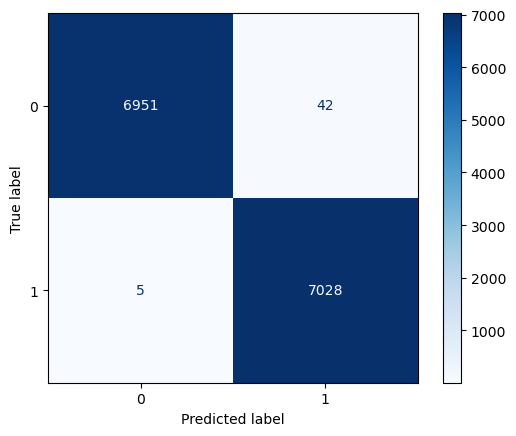

In [42]:
from sklearn.metrics import plot_confusion_matrix

# plot the matrix
plot_confusion_matrix(xgb_clf, X_test, y_test, cmap='Blues')
plt.show()

In [43]:
cost(y_test, xgb_clf.predict(X_test))

2920

### The best model with lowest false negative score is XGB Classifier with an accuracy of 99.6% on the test set